In [1]:
import os
import numpy as np
from PIL import Image

def load_and_downsample_images(image_folder, max_dim=500):
    images = []
    image_shapes = []
    image_names = []
    
    for filename in sorted(os.listdir(image_folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)
            img = Image.open(image_path).convert('RGB')
            w, h = img.size
            scale = min(max_dim / w, max_dim / h, 1)
            new_size = (int(w * scale), int(h * scale))
            img_resized = img.resize(new_size, Image.Resampling.LANCZOS)
            img_np = np.array(img_resized)
            images.append(img_np)
            image_shapes.append(img_np.shape[:2])
            image_names.append(filename)
    
    return images, image_shapes, image_names

image_folder = 'C:/Users/RCOM/Desktop/K-means Challenge/Images'
images, image_shapes, image_names = load_and_downsample_images(image_folder)
print(f"Loaded {len(images)} images")


Loaded 15 images


In [74]:
from sklearn.cluster import MiniBatchKMeans

def segment_image_minibatch_kmeans(features, k, image_shape):
    h, w = image_shape
    kmeans = MiniBatchKMeans(
    n_clusters=k,
    batch_size=10000,
    init="k-means++",
    random_state=42,
    n_init=10
)

    labels = kmeans.fit_predict(features)
    centers_rgb = kmeans.cluster_centers_[:, :3].astype(np.uint8)

    segmented_flat = centers_rgb[labels]
    segmented_img = segmented_flat.reshape(h, w, 3)
    return segmented_img, labels


In [3]:
def extract_rgb_xy_features(image_pixels, image_shape):
    """
    image_pixels: H x W x 3 RGB image
    image_shape: (height, width)
    """
    height, width = image_shape

    # Flatten RGB to (H*W, 3)
    rgb_flat = image_pixels.reshape(-1, 3).astype(np.float32)

    # 1D coordinate vectors of length H*W
    x_coords = np.tile(np.arange(width), height) / float(width)
    y_coords = np.repeat(np.arange(height), width) / float(height)

    # Stack to (H*W, 5)
    features = np.column_stack((rgb_flat, x_coords, y_coords))
    return features


In [4]:
def extract_features_for_all(images, image_shapes):
    all_features = []
    for img_pixels, shape in zip(images, image_shapes):
        features = extract_rgb_xy_features(img_pixels, shape)
        all_features.append(features)
    return all_features


features_all_images = extract_features_for_all(images, image_shapes)

# Check the shape of features for the first image
print(f'Features shape for first image: {features_all_images[0].shape}') 


Features shape for first image: (187125, 5)


In [5]:
from sklearn.cluster import KMeans

def segment_image_kmeans(features, k, image_shape):
    h, w = image_shape
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = kmeans.fit_predict(features)
    centers_rgb = kmeans.cluster_centers_[:, :3].astype(np.uint8)
    segmented_flat = centers_rgb[labels]
    segmented_img = segmented_flat.reshape(h, w, 3)
    return segmented_img, labels

Ks = [2, 3, 4, 5]
segmented_results = {}

for idx, (features, shape) in enumerate(zip(features_all_images, image_shapes)):
    print(f"Processing {image_names[idx]}...")
    segmented_results[idx] = {}
    for k in Ks:
        seg_img, labels = segment_image_kmeans(features, k, shape)
        segmented_results[idx][k] = {"image": seg_img, "labels": labels}

print("K-Means clustering complete!")


Processing image1.jpg...
Processing image10.jpg...
Processing image11.jpg...
Processing image12.png...
Processing image13.jpg...
Processing image14.jpg...
Processing image15.jpg...
Processing image2.jpg...
Processing image3.jpg...
Processing image4.jpg...
Processing image5.jpg...
Processing image6.jpg...
Processing image7.jpg...
Processing image8.jpg...
Processing image9.jpg...
K-Means clustering complete!


In [6]:
from sklearn.metrics import silhouette_score

def sampled_silhouette(features, labels, sample_size=5000):
    n = len(features)
    if n > sample_size:
        idx = np.random.choice(n, sample_size, replace=False)
        X_sample = features[idx]
        y_sample = labels[idx]
    else:
        X_sample = features
        y_sample = labels
    return silhouette_score(X_sample, y_sample)

silhouette_results = {}

for idx, features in enumerate(features_all_images):
    silhouette_results[idx] = {}
    for k in Ks:
        labels = segmented_results[idx][k]["labels"]
        score = sampled_silhouette(features, labels, sample_size=5000)
        silhouette_results[idx][k] = score
        print(f"{image_names[idx]}, K={k}: {score:.4f}")


image1.jpg, K=2: 0.5437
image1.jpg, K=3: 0.5938
image1.jpg, K=4: 0.4592
image1.jpg, K=5: 0.4953
image10.jpg, K=2: 0.4429
image10.jpg, K=3: 0.4061
image10.jpg, K=4: 0.4280
image10.jpg, K=5: 0.3287
image11.jpg, K=2: 0.9046
image11.jpg, K=3: 0.8909
image11.jpg, K=4: 0.8747
image11.jpg, K=5: 0.8610
image12.png, K=2: 0.6532
image12.png, K=3: 0.5536
image12.png, K=4: 0.5435
image12.png, K=5: 0.5149
image13.jpg, K=2: 0.4867
image13.jpg, K=3: 0.5252
image13.jpg, K=4: 0.4936
image13.jpg, K=5: 0.4869
image14.jpg, K=2: 0.5204
image14.jpg, K=3: 0.4694
image14.jpg, K=4: 0.4199
image14.jpg, K=5: 0.4333
image15.jpg, K=2: 0.9500
image15.jpg, K=3: 0.9342
image15.jpg, K=4: 0.9179
image15.jpg, K=5: 0.9059
image2.jpg, K=2: 0.6734
image2.jpg, K=3: 0.6941
image2.jpg, K=4: 0.6105
image2.jpg, K=5: 0.6160
image3.jpg, K=2: 0.5786
image3.jpg, K=3: 0.5716
image3.jpg, K=4: 0.5637
image3.jpg, K=5: 0.5718
image4.jpg, K=2: 0.7021
image4.jpg, K=3: 0.5006
image4.jpg, K=4: 0.5189
image4.jpg, K=5: 0.5205
image5.jpg, K=2:

In [7]:
from PIL import Image as PILImage

output_folder = "output_segments"
os.makedirs(output_folder, exist_ok=True)

for idx, name in enumerate(image_names):
    for k in Ks:
        seg_img = segmented_results[idx][k]["image"]
        base_name = os.path.splitext(name)[0]
        output_name = f"{base_name}_segmentedK{k}.png"
        output_path = os.path.join(output_folder, output_name)
        PILImage.fromarray(seg_img).save(output_path)
        print(f"Saved: {output_path}")

print("All 60 images saved!")


Saved: output_segments\image1_segmentedK2.png
Saved: output_segments\image1_segmentedK3.png
Saved: output_segments\image1_segmentedK4.png
Saved: output_segments\image1_segmentedK5.png
Saved: output_segments\image10_segmentedK2.png
Saved: output_segments\image10_segmentedK3.png
Saved: output_segments\image10_segmentedK4.png
Saved: output_segments\image10_segmentedK5.png
Saved: output_segments\image11_segmentedK2.png
Saved: output_segments\image11_segmentedK3.png
Saved: output_segments\image11_segmentedK4.png
Saved: output_segments\image11_segmentedK5.png
Saved: output_segments\image12_segmentedK2.png
Saved: output_segments\image12_segmentedK3.png
Saved: output_segments\image12_segmentedK4.png
Saved: output_segments\image12_segmentedK5.png
Saved: output_segments\image13_segmentedK2.png
Saved: output_segments\image13_segmentedK3.png
Saved: output_segments\image13_segmentedK4.png
Saved: output_segments\image13_segmentedK5.png
Saved: output_segments\image14_segmentedK2.png
Saved: output_seg

Running Elbow Method on image 1...


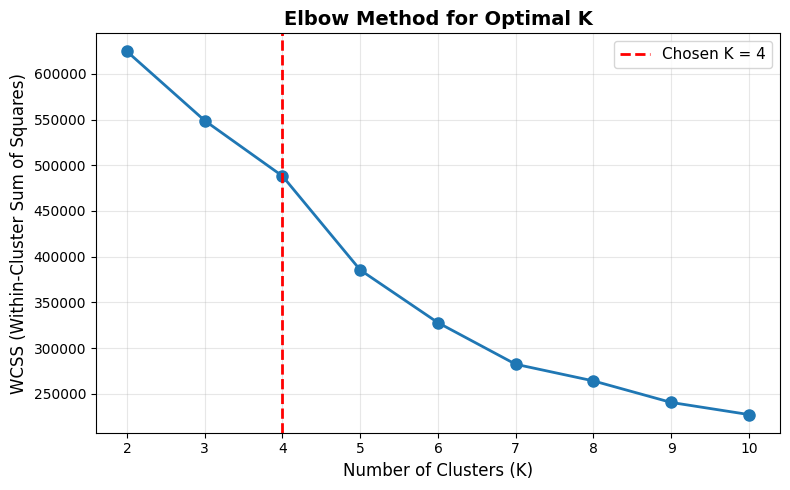

Recommended K: 4


In [9]:
import cv2

def choose_best_k_elbow(img_rgb, k_min=2, k_max=10, down_size=100):
    """
    Elbow method to find optimal K value.
    Downsamples image, computes WCSS for each K.
    """
    # Downsample for speed
    img_small = cv2.resize(img_rgb, (down_size, down_size))
    pixels = img_small.reshape(-1, 3).astype(np.float32)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    wcss = []
    ks = range(k_min, k_max + 1)
    
    for k in ks:
        _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
        labels = labels.flatten()
        distances = np.linalg.norm(pixels - centers[labels], axis=1)
        wcss.append(np.sum(distances))
    
    # Find elbow using second derivative
    diffs = np.diff(wcss)
    second_diffs = np.diff(diffs)
    elbow_index = np.argmax(second_diffs) + 2
    best_k = elbow_index
    
    # Plot elbow curve
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(ks, wcss, marker='o', linewidth=2, markersize=8)
    plt.axvline(best_k, color='red', linestyle='--', linewidth=2, label=f'Chosen K = {best_k}')
    plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Clusters (K)', fontsize=12)
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    return best_k

# Test on first image only (for speed)
print("Running Elbow Method on image 1...")
best_k = choose_best_k_elbow(images[0])
print(f"Recommended K: {best_k}")


In [10]:
import cv2

def extract_lab_xy_features(image_rgb, image_shape):
    """Extract Lab color space + XY features."""
    height, width = image_shape
    
    # Convert RGB to Lab
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    lab_flat = image_lab.reshape(-1, 3).astype(np.float32)
    
    # Normalized coordinates
    x_coords = np.tile(np.arange(width), height) / float(width)
    y_coords = np.repeat(np.arange(height), width) / float(height)
    
    # Stack Lab + XY
    features = np.column_stack((lab_flat, x_coords, y_coords))
    return features

# Extract Lab features for all images
print("Extracting Lab+XY features...")
lab_features_all = []
for img, shape in zip(images, image_shapes):
    feats = extract_lab_xy_features(img, shape)
    lab_features_all.append(feats)

print(f"Lab features extracted: {len(lab_features_all)} images")

# Compare RGB vs Lab on first 3 images
print("\n=== LAB vs RGB Comparison ===")
for idx in range(min(3, len(images))):
    print(f"\n{image_names[idx]}:")
    rgb_score = silhouette_results[idx][2]
    
    # Compute silhouette for Lab on K=2
    kmeans_lab = KMeans(n_clusters=2, init="k-means++", n_init=10, random_state=42)
    labels_lab = kmeans_lab.fit_predict(lab_features_all[idx])
    lab_score = sampled_silhouette(lab_features_all[idx], labels_lab, sample_size=5000)
    
    print(f"  RGB+XY (K=2): {rgb_score:.4f}")
    print(f"  Lab+XY (K=2): {lab_score:.4f}")
    print(f"  Difference: {rgb_score - lab_score:+.4f}")


Extracting Lab+XY features...
Lab features extracted: 15 images

=== LAB vs RGB Comparison ===

image1.jpg:
  RGB+XY (K=2): 0.5437
  Lab+XY (K=2): 0.5065
  Difference: +0.0372

image10.jpg:
  RGB+XY (K=2): 0.4429
  Lab+XY (K=2): 0.4349
  Difference: +0.0080

image11.jpg:
  RGB+XY (K=2): 0.9046
  Lab+XY (K=2): 0.9126
  Difference: -0.0080


In [11]:
import cv2

def apply_gaussian_blur(image_rgb, kernel_size=(5, 5), sigma=1.5):
    """Apply Gaussian blur to image."""
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    blurred_bgr = cv2.GaussianBlur(image_bgr, kernel_size, sigma)
    blurred_rgb = cv2.cvtColor(blurred_bgr, cv2.COLOR_BGR2RGB)
    return blurred_rgb

# Apply blur to all images and extract features
print("Applying Gaussian blur to all images...")
blurred_images = [apply_gaussian_blur(img) for img in images]
blurred_features = []
for blurred_img, shape in zip(blurred_images, image_shapes):
    feats = extract_rgb_xy_features(blurred_img, shape)
    blurred_features.append(feats)

print(f"Blurred features extracted: {len(blurred_features)} images")

# Compare original vs blurred on first 2 images
print("\n=== ORIGINAL vs BLURRED Comparison ===")
for idx in range(min(2, len(images))):
    print(f"\n{image_names[idx]}:")
    original_score = silhouette_results[idx][2]
    
    kmeans_blur = KMeans(n_clusters=2, init="k-means++", n_init=10, random_state=42)
    labels_blur = kmeans_blur.fit_predict(blurred_features[idx])
    blurred_score = sampled_silhouette(blurred_features[idx], labels_blur, sample_size=5000)
    
    print(f"  Original RGB+XY (K=2): {original_score:.4f}")
    print(f"  Blurred RGB+XY (K=2):  {blurred_score:.4f}")
    print(f"  Difference: {blurred_score - original_score:+.4f}")


Applying Gaussian blur to all images...
Blurred features extracted: 15 images

=== ORIGINAL vs BLURRED Comparison ===

image1.jpg:
  Original RGB+XY (K=2): 0.5437
  Blurred RGB+XY (K=2):  0.5467
  Difference: +0.0031

image10.jpg:
  Original RGB+XY (K=2): 0.4429
  Blurred RGB+XY (K=2):  0.4423
  Difference: -0.0006


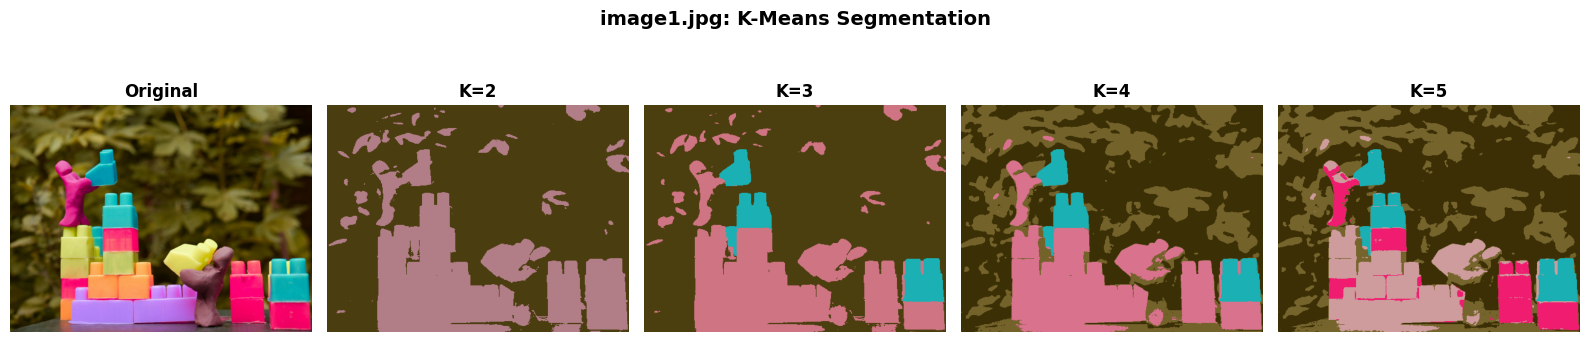

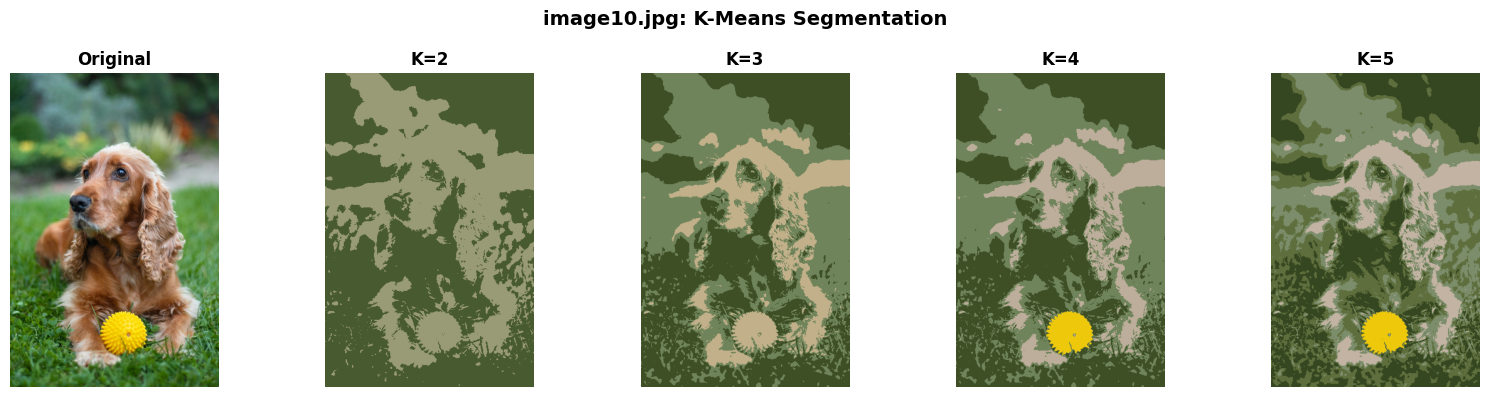

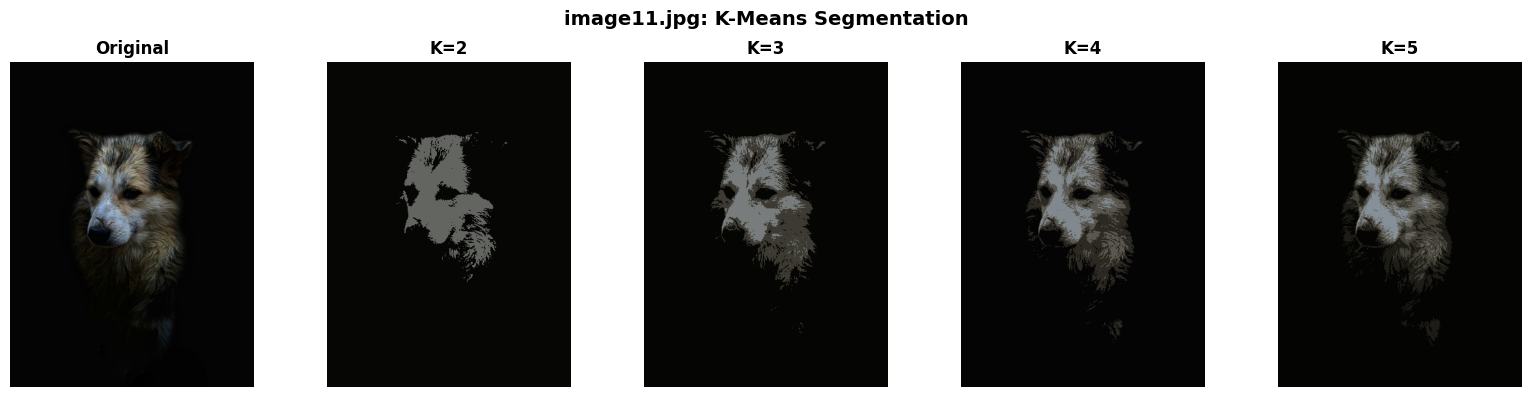

In [12]:
import matplotlib.pyplot as plt

def plot_segmentations(original_img, segmented_images, ks, title=""):
    """Display original + segmented images for different K values."""
    n_plots = len(ks) + 1
    plt.figure(figsize=(16, 4))
    
    # Original image
    plt.subplot(1, n_plots, 1)
    plt.imshow(original_img)
    plt.title("Original", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Segmented images
    for i, k in enumerate(ks):
        plt.subplot(1, n_plots, i + 2)
        plt.imshow(segmented_images[k])
        plt.title(f"K={k}", fontsize=12, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize first 3 images
for idx in range(min(3, len(images))):
    seg_imgs = {k: segmented_results[idx][k]["image"] for k in Ks}
    plot_segmentations(images[idx], seg_imgs, Ks, title=f"{image_names[idx]}: K-Means Segmentation")


In [13]:
import pandas as pd

# Create comprehensive summary
print("\n" + "="*70)
print("FINAL PROJECT SUMMARY")
print("="*70)

# Statistics by K
print("\n1. SILHOUETTE SCORES BY K:")
print("-" * 50)
for k in Ks:
    scores = [silhouette_results[idx][k] for idx in range(len(images))]
    print(f"K={k}: Mean={np.mean(scores):.4f}, Min={np.min(scores):.4f}, Max={np.max(scores):.4f}")

# Best K per image
print("\n2. BEST K FOR EACH IMAGE:")
print("-" * 50)
best_k_list = []
for idx in range(len(images)):
    best_k = max(Ks, key=lambda k: silhouette_results[idx][k])
    best_k_list.append(best_k)
    print(f"{image_names[idx]:20s} → K={best_k} (Score: {silhouette_results[idx][best_k]:.4f})")

# Top 3 images
print("\n3. TOP 3 BEST PERFORMING IMAGES:")
print("-" * 50)
scores_summary = [(idx, max([silhouette_results[idx][k] for k in Ks])) for idx in range(len(images))]
scores_summary.sort(key=lambda x: x[1], reverse=True)
for rank, (idx, score) in enumerate(scores_summary[:3], 1):
    print(f"{rank}. {image_names[idx]:20s} - Silhouette: {score:.4f}")

# Save complete results
summary_data = []
for idx in range(len(images)):
    for k in Ks:
        summary_data.append({
            'Image': image_names[idx],
            'K': k,
            'Silhouette_Score': silhouette_results[idx][k],
            'Best_K': best_k_list[idx]
        })

df_summary = pd.DataFrame(summary_data)
df_summary.to_csv('segmentation_results_complete.csv', index=False)
print("\n✓ Results saved to 'segmentation_results_complete.csv'")

print("\n" + "="*70)
print("PROJECT COMPLETE!")
print("="*70)
print(f"Total images processed: {len(images)}")
print(f"Total segmented outputs: {len(images) * len(Ks)}")
print(f"Output folder: output_segments/")



FINAL PROJECT SUMMARY

1. SILHOUETTE SCORES BY K:
--------------------------------------------------
K=2: Mean=0.6439, Min=0.4429, Max=0.9500
K=3: Mean=0.6073, Min=0.4061, Max=0.9342
K=4: Mean=0.5753, Min=0.4199, Max=0.9179
K=5: Mean=0.5715, Min=0.3287, Max=0.9059

2. BEST K FOR EACH IMAGE:
--------------------------------------------------
image1.jpg           → K=3 (Score: 0.5938)
image10.jpg          → K=2 (Score: 0.4429)
image11.jpg          → K=2 (Score: 0.9046)
image12.png          → K=2 (Score: 0.6532)
image13.jpg          → K=3 (Score: 0.5252)
image14.jpg          → K=2 (Score: 0.5204)
image15.jpg          → K=2 (Score: 0.9500)
image2.jpg           → K=3 (Score: 0.6941)
image3.jpg           → K=2 (Score: 0.5786)
image4.jpg           → K=2 (Score: 0.7021)
image5.jpg           → K=2 (Score: 0.5667)
image6.jpg           → K=2 (Score: 0.7630)
image7.jpg           → K=2 (Score: 0.7078)
image8.jpg           → K=5 (Score: 0.6162)
image9.jpg           → K=2 (Score: 0.5808)

3. TOP 3 B